- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [269]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

In [270]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [271]:
# Kaggle의 smartphone cost classification data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DL/train.csv")

In [272]:
data

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [274]:
input = data.drop(['price_range'], axis=1)
output = data.price_range

battery_power


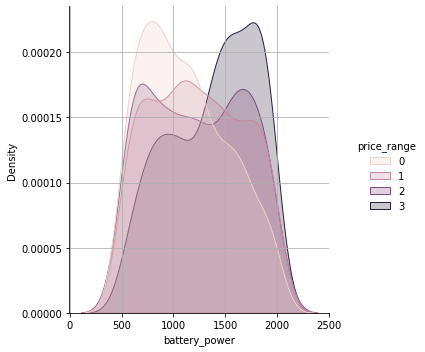

blue


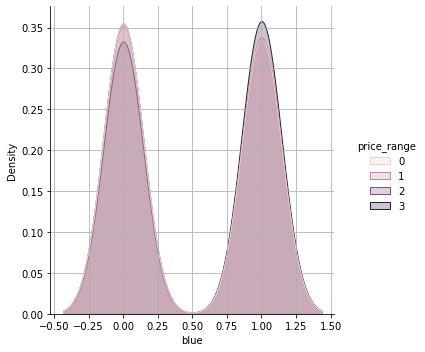

clock_speed


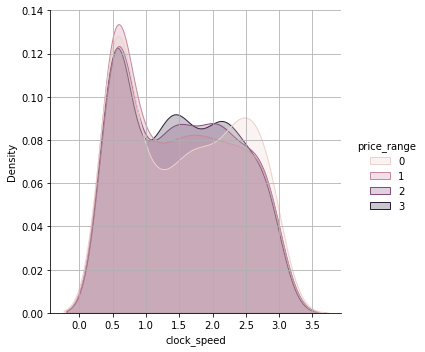

dual_sim


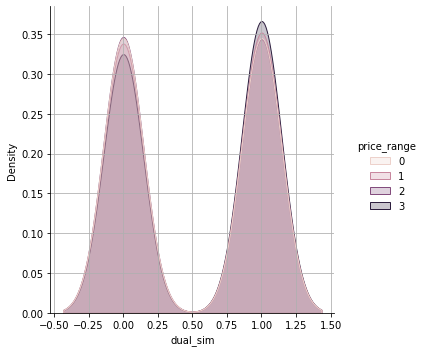

fc


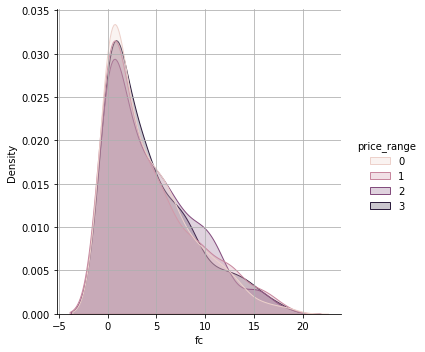

four_g


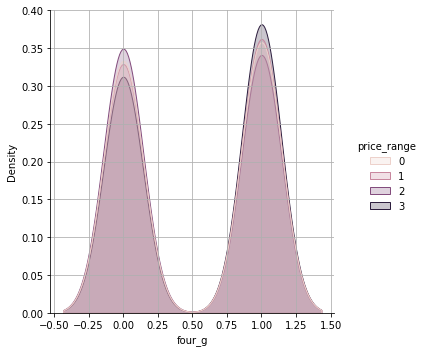

int_memory


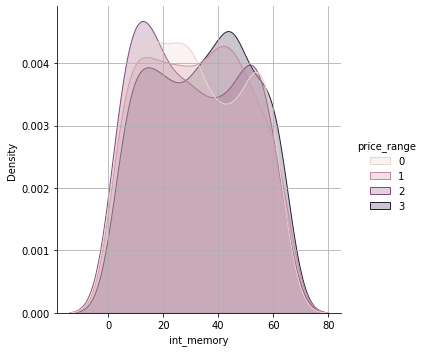

m_dep


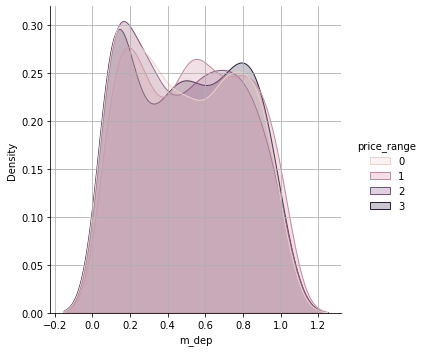

mobile_wt


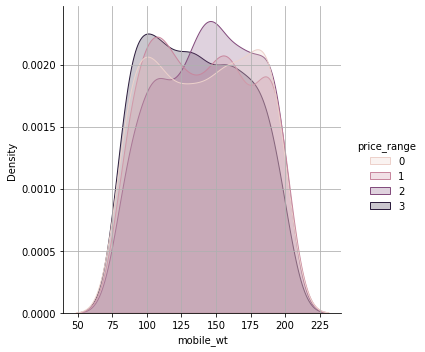

n_cores


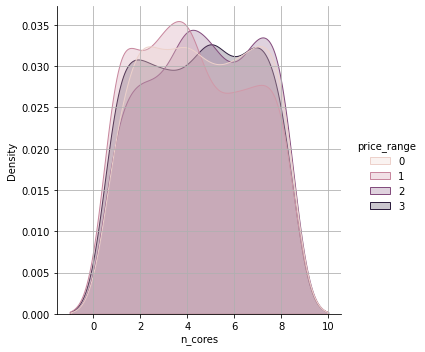

pc


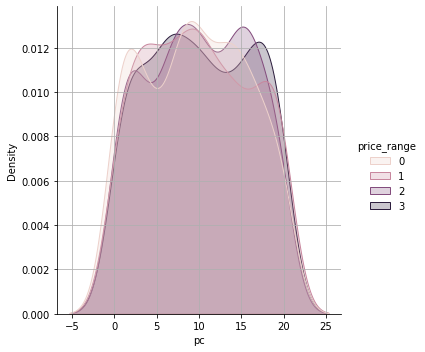

px_height


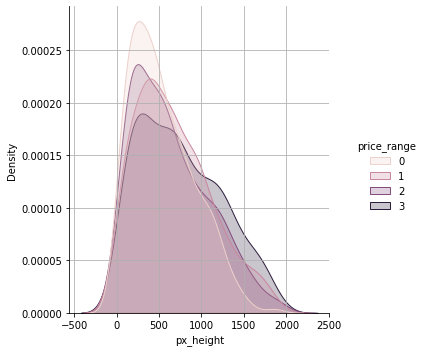

px_width


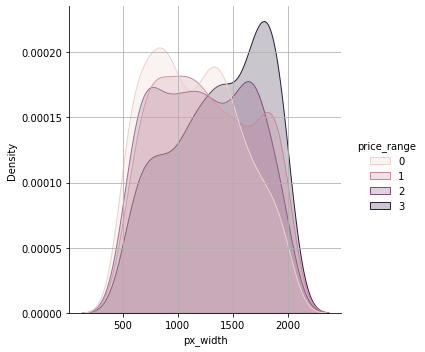

ram


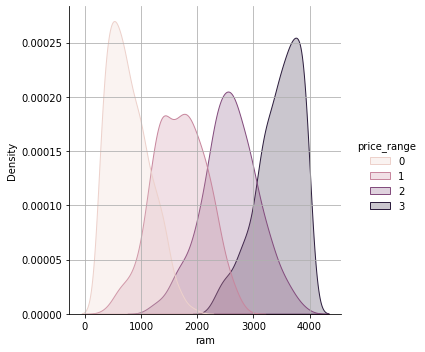

sc_h


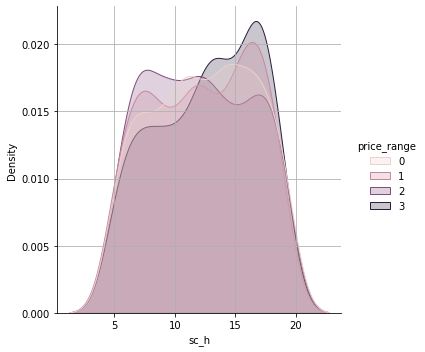

sc_w


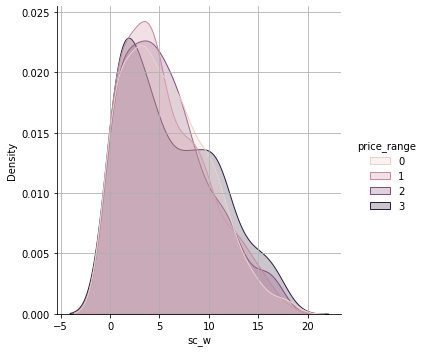

talk_time


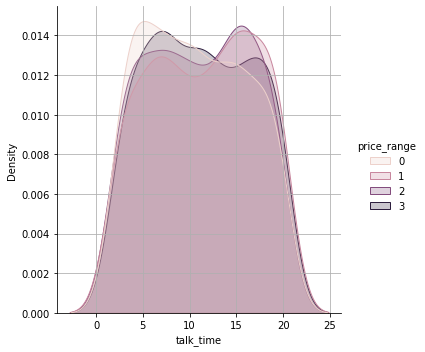

three_g


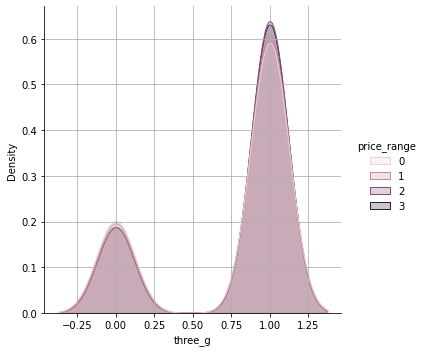

touch_screen


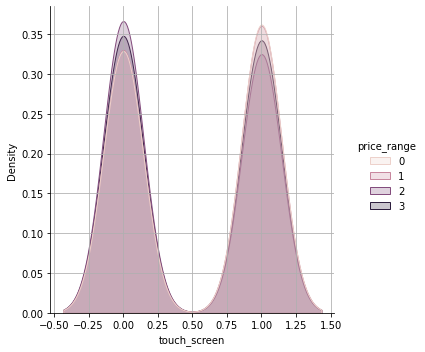

wifi


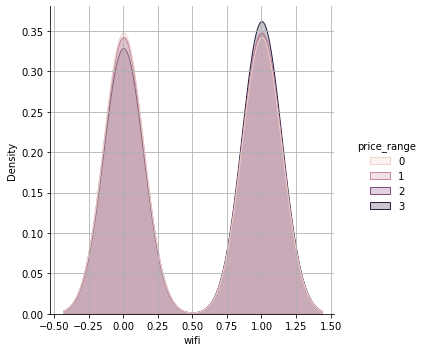

In [275]:
#EDA
for colm in data.select_dtypes(np.number).columns[:-1]:
    
    print(colm) 
    #sns.displot(data, x = colm,  hue="price_range")
    sns.displot(data, x = colm,  hue="price_range", kind="kde", fill=True)
    plt.grid()
    plt.show()

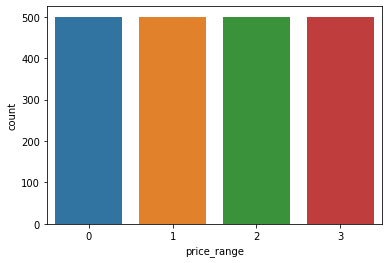

In [276]:
# 골고루 분포되어있어서 오버샘플링 따로 필요없다
sns.countplot(x = 'price_range' , data = data)

In [277]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [278]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.price_range, shuffle = True)

x_train = torch.FloatTensor(x_train.values).to(device)
y_train = torch.LongTensor(y_train.values).to(device)
x_test = torch.FloatTensor(x_test.values)
y_test = torch.LongTensor(y_test.values)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [279]:
print(x_train[0])
print(y_train[0])

#input 20개 (속성이 20개)
#y의 class는 4개 (0,1,2,3)

tensor([8.0700e+02, 1.0000e+00, 5.0000e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7000e+01, 2.0000e-01, 1.2700e+02, 4.0000e+00, 0.0000e+00, 2.4500e+02,
        8.2900e+02, 2.3190e+03, 5.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], device='cuda:0')
tensor(1, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [280]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [281]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [282]:
model = nn.Sequential(
          nn.Linear(30,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,4, bias=True), 
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

# Model1 - 기본 제공 모델

In [283]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(20,398, bias=True), # input_layer = 20, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 4, bias=True), # hidden_layer3 = 10, output_layer = 4
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [284]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [285]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=4, bias=True)
    (1): Softmax(dim=None)
  )
)

In [286]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=4, bias=True)
    (1): Softmax(dim=None)
  )
)


In [287]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [288]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.3948723077774048
10 1.314161777496338
20 1.2644449472427368


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


30 1.2180700302124023
40 1.1718837022781372
50 1.1352571249008179
60 1.1167467832565308
70 1.1018304824829102
80 1.104492425918579
90 1.0976581573486328


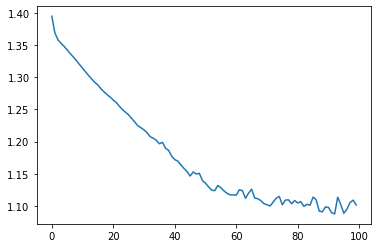

In [289]:
plt.plot(losses)
plt.show()

In [290]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [291]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.0017568  0.01271942 0.1913803  0.79414356]
argmax를 한 후의 output은 3
accuracy는 0.6333333333333333


In [292]:
result = pd.DataFrame(columns=['activation_f','optimizer','epoch', 'layer','lr','accuracy'])

In [293]:
new_row = {'activation_f':'Sigmoid','optimizer':'Adam','epoch':100, 'layer':4,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

# Model2
- 첫번째, 두번째 층에 배치정규화, 활성화함수는 tanh()

In [294]:
class Model(torch.nn.Module):

  def __init__(self):
    
    super().__init__()
    
    self.layer1 = nn.Sequential(
          nn.Linear(20,64, bias=True),
          nn.Tanh(),
        nn.BatchNorm1d(64)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(64,32, bias=True),
        nn.Tanh(),
        nn.BatchNorm1d(32)
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,16, bias=True), 
        nn.Tanh()
    )
    self.layer4 = nn.Sequential(
          nn.Linear(16,4, bias=True), 
        nn.Tanh()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [295]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): Tanh()
  )
)

In [296]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): Tanh()
  )
)


In [297]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [298]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.331551432609558
10 1.0531113147735596
20 1.0122816562652588
30 0.989161491394043
40 1.01007878780365
50 0.9924046993255615
60 0.9902581572532654
70 0.9802326560020447
80 0.9872114062309265
90 1.0035942792892456
100 0.9630110263824463
110 0.9519355893135071
120 0.9648498296737671
130 0.9762609004974365
140 0.9571745991706848
150 0.9442890286445618
160 0.908323347568512
170 0.946918785572052
180 0.9474157094955444
190 0.9211970567703247
200 0.9718666076660156
210 0.957414448261261
220 0.8820002675056458
230 0.8681020736694336
240 0.8800565004348755
250 0.8647297620773315
260 0.8834730982780457
270 0.8641480207443237
280 0.9098224639892578
290 0.8889333605766296
300 0.8730818629264832
310 0.8978380560874939
320 0.872692346572876
330 0.8556917309761047
340 0.8504282236099243
350 0.8774988055229187
360 0.9040265083312988
370 0.8463581800460815
380 0.8699849247932434
390 0.8703524470329285
400 0.9003894925117493
410 0.8504957556724548
420 0.8510762453079224
430 0.901611328125
440 0.86218

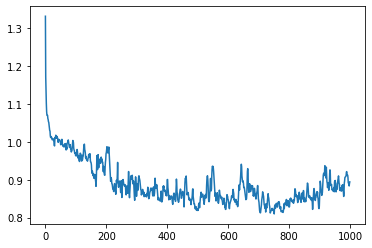

In [299]:
plt.plot(losses)
plt.show()

In [300]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [301]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [-0.99982035 -0.93652785  0.17175631  0.9998892 ]
argmax를 한 후의 output은 3
accuracy는 0.6


In [302]:
new_row = {'activation_f':'tanh','optimizer':'Adam','epoch':1000, 'layer':4,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

#Model3
- Relu 함수 활용 - 제공되는걸로, 첫번째 배치정규화

In [303]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(20,64, bias=True),
          nn.ReLU(),
        nn.BatchNorm1d(64)
    )


    self.layer2 = nn.Sequential(
          nn.Linear(64,32, bias=True),
        nn.ReLU()
    
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,16, bias=True),
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 4, bias=True), 
        nn.ReLU()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [304]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [305]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): ReLU()
  )
)

In [306]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): ReLU()
  )
)


In [307]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [308]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.4809908866882324
10 0.47128331661224365
20 0.145673930644989
30 0.07129324972629547
40 0.04627464339137077
50 0.033457983285188675
60 0.02485485002398491
70 0.018966682255268097
80 0.014528627507388592
90 0.011403478682041168
100 0.008981944061815739
110 0.00707200588658452
120 0.005714963655918837
130 0.004401592072099447
140 0.003537548938766122
150 0.0028333135414868593
160 0.0022415597923099995
170 0.0018073905957862735
180 0.001516032381914556
190 0.001266365172341466
200 0.0010831825202330947
210 0.0009331274195574224
220 0.0008137684199027717
230 0.0007183279376477003
240 0.0006395095842890441
250 0.0005728635005652905
260 0.0005178011488169432
270 0.0004701220022980124
280 0.00043158134212717414
290 0.00039081572322174907
300 0.0003575641894713044
310 0.0003289126616436988
320 0.0003049338120035827
330 0.00028045132057741284
340 0.0002595926052890718
350 0.00024117175780702382
360 0.0002252919366583228
370 0.0002105818421114236
380 0.00019800096924882382
390 0.0001863955840

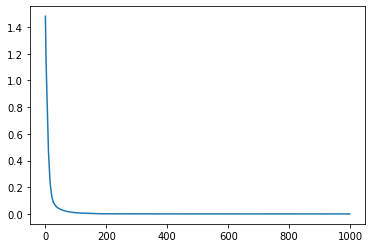

In [309]:
plt.plot(losses)
plt.show()

In [310]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [311]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [ 0.        0.       35.332222 94.98906 ]
argmax를 한 후의 output은 3
accuracy는 0.9733333333333334


In [312]:
new_row = {'activation_f':'nn.Relu','optimizer':'Adam','epoch':1000, 'layer':4,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

# Model4
-직접 정의한 Relu함수 사용

In [313]:
def relu(x):
  a = torch.zeros_like(x)
  return torch.max(x, a)

In [314]:
class Model(torch.nn.Module):

  def __init__(self):
    
    super().__init__()
    
    self.layer1 = nn.Linear(20,64, bias=True)
    self.bnorm1 = nn.BatchNorm1d(64)
    self.layer2 = nn.Linear(64,32, bias=True)
    self.bnorm2 = nn.BatchNorm1d(32)
    self.layer3 = nn.Linear(32,16, bias=True)
    self.layer4 = nn.Linear(16,4, bias=True)


   
    
  def forward(self,x):
    
    output = self.layer1(x)
    output = F.relu(output)
    output = self.bnorm1(output)
    output = F.relu(output)
    output = self.layer2(output)
    output = self.bnorm2(output)
    output = self.layer3(output)
    output = F.relu(output)
    output = self.layer4(output)
    return output

In [315]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [316]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Linear(in_features=20, out_features=64, bias=True)
  (bnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (bnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
)

In [317]:
print(model)

Model(
  (layer1): Linear(in_features=20, out_features=64, bias=True)
  (bnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (bnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
)


In [318]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [319]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.5072695016860962
10 0.36752694845199585
20 0.16935470700263977
30 0.09824018180370331
40 0.061918843537569046
50 0.042272817343473434
60 0.029572492465376854
70 0.023530445992946625
80 0.02080865018069744
90 0.01893102563917637
100 0.013264601118862629
110 0.009122790768742561
120 0.006812116596847773
130 0.005163094960153103
140 0.004001804161816835
150 0.0031866529025137424
160 0.002583900699391961
170 0.002130130073055625
180 0.0017805431270971894
190 0.0014927799347788095
200 0.0012698989594355226
210 0.0010884222574532032
220 0.0009452481754124165
230 0.0008262940682470798
240 0.000729705614503473
250 0.0006491455133073032
260 0.0005820043734274805
270 0.0005250803660601377
280 0.00047631669440306723
290 0.0004335751582402736
300 0.00039674140862189233
310 0.00036462766001932323
320 0.00033633384737186134
330 0.0003115682047791779
340 0.0002886077854782343
350 0.00026826420798897743
360 0.0002500536502338946
370 0.00023349504044745117
380 0.00021881052816752344
390 0.000205326

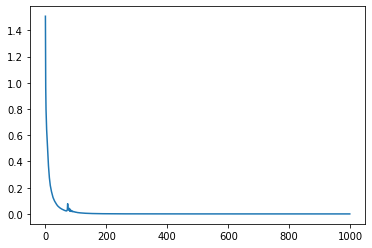

In [320]:
plt.plot(losses)
plt.show()

In [321]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [322]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [-20.21246    -34.492       -0.25871864  41.448616  ]
argmax를 한 후의 output은 3
accuracy는 0.9516666666666667


In [323]:
new_row = {'activation_f':'F.relu','optimizer':'Adam','epoch':1000, 'layer':4,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

#Model5
-LeakyRelu, adam

In [324]:
class Model(torch.nn.Module):

  def __init__(self):
    
    super().__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(20,64, bias=True),
        nn.LeakyReLU(),
        nn.BatchNorm1d(64)
    )

    self.layer2 = nn.Sequential(
        nn.Linear(64,32, bias=True),
        nn.LeakyReLU()
    )
    self.layer3 = nn.Sequential(
        nn.Linear(32,16, bias=True),
        nn.LeakyReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 4, bias=True), 
        nn.LeakyReLU()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [325]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)

In [326]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)


In [327]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [328]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.329804539680481
10 0.4135156571865082
20 0.13710546493530273
30 0.064700648188591
40 0.04021857678890228
50 0.02830730937421322
60 0.021032441407442093
70 0.015957873314619064
80 0.012785828672349453
90 0.010129922069609165
100 0.00839392188936472
110 0.006536380387842655
120 0.005908046383410692
130 0.004751094616949558
140 0.003926232922822237
150 0.002822429873049259
160 0.0022575242910534143
170 0.0017803023802116513
180 0.0014748451067134738
190 0.001243575825355947
200 0.001043942989781499
210 0.0008968543261289597
220 0.0007881746278144419
230 0.0006837850087322295
240 0.0006124021019786596
250 0.0005452714976854622
260 0.0004888211842626333
270 0.00044028402771800756
280 0.000404210266424343
290 0.00036418568925000727
300 0.00033693609293550253
310 0.00030819838866591454
320 0.00028592871967703104
330 0.00026565304142422974
340 0.00024804059648886323
350 0.00023160057025961578
360 0.00021708190615754575
370 0.00020396230684127659
380 0.0001917043118737638
390 0.000181131486

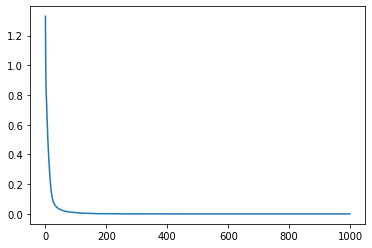

In [329]:
plt.plot(losses)
plt.show()

In [330]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [331]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [-0.42447445 -0.3412532  27.767452   67.55106   ]
argmax를 한 후의 output은 3
accuracy는 0.97


In [332]:
new_row = {'activation_f':'nn.LeakyReLU','optimizer':'Adam','epoch':1000, 'layer':4,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

# Model6
- Optimizer변경: SGD로

In [333]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(20,64, bias=True),
          nn.ReLU(),
        nn.BatchNorm1d(64)
    )


    self.layer2 = nn.Sequential(
          nn.Linear(64,32, bias=True),
        nn.ReLU()
    
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,16, bias=True),
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 4, bias=True), 
        nn.ReLU()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [334]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): ReLU()
  )
)

In [335]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): ReLU()
  )
)


In [336]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [337]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.4323495626449585
10 1.105473518371582
20 0.8727229237556458
30 0.7444635033607483
40 0.6623276472091675
50 0.6139952540397644
60 0.5822336077690125
70 0.5588467717170715
80 0.538932740688324
90 0.5200392007827759
100 0.4985901713371277
110 0.47054365277290344
120 0.43647700548171997
130 0.38806474208831787
140 0.3066071569919586
150 0.2465198040008545
160 0.2090664952993393
170 0.18295209109783173
180 0.16358759999275208
190 0.14892332255840302
200 0.1374373883008957
210 0.1280946135520935
220 0.1204414889216423
230 0.11392632871866226
240 0.10841178894042969
250 0.10359438508749008
260 0.09945695102214813
270 0.09582164138555527
280 0.09262678772211075
290 0.08971033990383148
300 0.08701631426811218
310 0.08452187478542328
320 0.0821886882185936
330 0.0799940899014473
340 0.07787786424160004
350 0.07592311501502991
360 0.07415684312582016
370 0.0725470632314682
380 0.07104508578777313
390 0.0696076825261116
400 0.06823812425136566
410 0.06689342856407166
420 0.06561775505542755
43

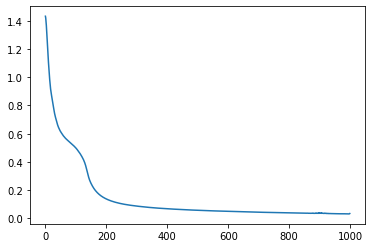

In [338]:
plt.plot(losses)
plt.show()

In [339]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [340]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [ 0.       0.      19.54913 33.76447]
argmax를 한 후의 output은 3
accuracy는 0.9783333333333334


In [341]:
new_row = {'activation_f':'nn.Relu','optimizer':'SGD','epoch':1000, 'layer':4,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

#Model7 
- leakyRelu 활성화함수 사용, SGD

In [342]:
class Model(torch.nn.Module):

  def __init__(self):
    
    super().__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(20,64, bias=True),
        nn.LeakyReLU(),
        nn.BatchNorm1d(64)
    )

    self.layer2 = nn.Sequential(
        nn.Linear(64,32, bias=True),
        nn.LeakyReLU()
    )
    self.layer3 = nn.Sequential(
        nn.Linear(32,16, bias=True),
        nn.LeakyReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 4, bias=True), 
        nn.LeakyReLU()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [343]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)

In [344]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)


In [345]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [346]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.4643774032592773
10 1.1903492212295532
20 1.1018272638320923
30 0.938890814781189
40 0.885148286819458
50 0.8085344433784485
60 0.7295868992805481
70 0.6670535206794739
80 0.6246618628501892
90 0.594940721988678
100 0.5712125897407532
110 0.5514147281646729
120 0.5347552299499512
130 0.5205494165420532
140 0.5083823204040527
150 0.4979037940502167
160 0.4889145791530609
170 0.48112574219703674
180 0.47424691915512085
190 0.468161940574646
200 0.46268972754478455
210 0.4578089118003845
220 0.45339587330818176
230 0.4492897689342499
240 0.44544342160224915
250 0.4418211281299591
260 0.4383864402770996
270 0.43503156304359436
280 0.43160051107406616
290 0.427902489900589
300 0.4234914779663086
310 0.41558364033699036
320 0.3912231922149658
330 0.29488569498062134
340 0.18195487558841705
350 0.1297776699066162
360 0.10701610147953033
370 0.09374012798070908
380 0.0853436142206192
390 0.07928911596536636
400 0.07456967234611511
410 0.07069884985685349
420 0.06747456640005112
430 0.06470

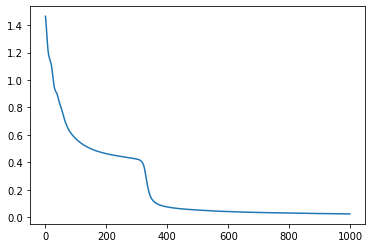

In [347]:
plt.plot(losses)
plt.show()

In [348]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [349]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [-0.15201822 -0.07161145 19.436188   38.727745  ]
argmax를 한 후의 output은 3
accuracy는 0.98


In [350]:
new_row = {'activation_f':'nn.LeakyReLU','optimizer':'SGD','epoch':1000, 'layer':4,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

#Model 8
층의 개수를 하나 줄여봄

In [351]:
class Model(torch.nn.Module):

  def __init__(self):
    
    super().__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(20,64, bias=True),
        nn.LeakyReLU(),
        nn.BatchNorm1d(64)
    )

    self.layer2 = nn.Sequential(
        nn.Linear(64,16, bias=True),
        nn.LeakyReLU()
    )
    self.layer3 = nn.Sequential(
        nn.Linear(16,4, bias=True),
        nn.LeakyReLU()
    )
  
  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    return output

In [352]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)

In [353]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)


In [354]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [355]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.5773100852966309
10 0.9682134985923767
20 0.6916682720184326
30 0.5836169719696045
40 0.5019147396087646
50 0.43390676379203796
60 0.3739478290081024
70 0.3276630938053131
80 0.29165735840797424
90 0.26317310333251953
100 0.24216493964195251
110 0.2234487533569336
120 0.2077268809080124
130 0.195430189371109
140 0.1856648027896881
150 0.17754772305488586
160 0.17044217884540558
170 0.1641615927219391
180 0.15829326212406158
190 0.15305013954639435
200 0.14835983514785767
210 0.14375925064086914
220 0.13892431557178497
230 0.13264648616313934
240 0.13473111391067505
250 0.12943589687347412
260 0.12601293623447418
270 0.12296155840158463
280 0.12007296830415726
290 0.11734682321548462
300 0.11493046581745148
310 0.11253010481595993
320 0.11007184535264969
330 0.10764268040657043
340 0.10513187199831009
350 0.10251633822917938
360 0.09950583428144455
370 0.09554705768823624
380 0.09395904839038849
390 0.09221150726079941
400 0.09055834263563156
410 0.08911825716495514
420 0.0877510532

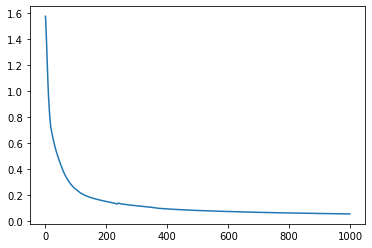

In [356]:
plt.plot(losses)
plt.show()

In [357]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [358]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [-0.10191409 -0.05686259 15.336512   27.786077  ]
argmax를 한 후의 output은 3
accuracy는 0.9783333333333334


In [359]:
new_row = {'activation_f':'nn.LeakyReLU','optimizer':'SGD','epoch':1000, 'layer':3,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

In [360]:
result

,activation_f,optimizer,epoch,layer,lr,accuracy
0,Sigmoid,Adam,100,4,0.01,0.633333
1,tanh,Adam,1000,4,0.01,0.600000
2,nn.Relu,Adam,1000,4,0.01,0.973333
3,F.relu,Adam,1000,4,0.01,0.951667
4,nn.LeakyReLU,Adam,1000,4,0.01,0.970000
5,nn.Relu,SGD,1000,4,0.01,0.978333
6,nn.LeakyReLU,SGD,1000,4,0.01,0.980000
7,nn.LeakyReLU,SGD,1000,3,0.01,0.978333


#Model9
- Model7에서 RMSprop optimizer 사용

In [361]:
class Model(torch.nn.Module):

  def __init__(self):
    
    super().__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(20,64, bias=True),
        nn.LeakyReLU(),
        nn.BatchNorm1d(64)
    )

    self.layer2 = nn.Sequential(
        nn.Linear(64,32, bias=True),
        nn.LeakyReLU()
    )
    self.layer3 = nn.Sequential(
        nn.Linear(32,16, bias=True),
        nn.LeakyReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 4, bias=True), 
        nn.LeakyReLU()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [362]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)

In [363]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)


In [364]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.RMSprop(model.parameters(), lr=0.01)

In [365]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.373666763305664
10 1.256460189819336
20 1.1170272827148438
30 0.8621276021003723
40 0.7205294370651245
50 0.6181418299674988
60 0.5046564340591431
70 0.2836325168609619
80 0.2297380566596985
90 0.10552569478750229
100 0.14142008125782013
110 0.11274808645248413
120 0.09794963151216507
130 0.06137783080339432
140 0.12890416383743286
150 0.10427962988615036
160 0.050045110285282135
170 0.1393323838710785
180 0.05699320137500763
190 0.04182158410549164
200 0.07260730117559433
210 0.15225248038768768
220 0.0968998596072197
230 0.033425893634557724
240 0.03394237533211708
250 0.43472111225128174
260 0.028259258717298508
270 0.027944087982177734
280 0.09382674098014832
290 0.12641872465610504
300 0.026073679327964783
310 0.021609261631965637
320 0.35344427824020386
330 0.028521820902824402
340 0.027337603271007538
350 0.22669023275375366
360 0.02327267825603485
370 0.022835426032543182
380 0.05094975605607033
390 0.024805067107081413
400 0.041931796818971634
410 0.08886945247650146
420 0

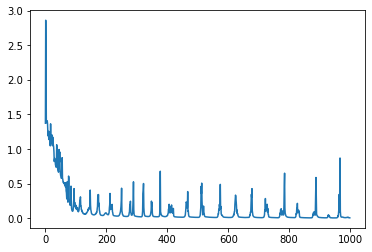

In [366]:
plt.plot(losses)
plt.show()

In [367]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [368]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [-0.23102632 -0.34413978  3.75954    22.181538  ]
argmax를 한 후의 output은 3
accuracy는 0.965


In [369]:
new_row = {'activation_f':'nn.LeakyReLU','optimizer':'RMSprop','epoch':1000, 'layer':4,'lr':0.01,'accuracy':accuracy}
result = result.append(new_row, ignore_index=True)

#Model 10
 - model7에서 뉴런개수만 바꿈



In [370]:
class Model(torch.nn.Module):

  def __init__(self):
    
    super().__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(20,256, bias=True),
        nn.LeakyReLU(),
        nn.BatchNorm1d(256)
    )

    self.layer2 = nn.Sequential(
        nn.Linear(256,64, bias=True),
        nn.LeakyReLU()
    )
    self.layer3 = nn.Sequential(
        nn.Linear(64,16, bias=True),
        nn.LeakyReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 4, bias=True), 
        nn.LeakyReLU()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [371]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)

In [372]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)


In [373]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [374]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.4752789735794067
10 0.8784638047218323
20 0.572481095790863
30 0.3840165138244629
40 0.24822738766670227
50 0.18562129139900208
60 0.14985540509223938
70 0.12857989966869354
80 0.11375917494297028
90 0.10330626368522644
100 0.09504838287830353
110 0.08830739557743073
120 0.08265208452939987
130 0.07773253321647644
140 0.07336723059415817
150 0.06946466863155365
160 0.06598410755395889
170 0.06270206719636917
180 0.05953739210963249
190 0.056575678288936615
200 0.054286930710077286
210 0.05209553241729736
220 0.05007757991552353
230 0.04822701960802078
240 0.04653452709317207
250 0.04496966674923897
260 0.04350351169705391
270 0.04214927926659584
280 0.04085926339030266
290 0.039645954966545105
300 0.03848255053162575
310 0.03740581497550011
320 0.03641914203763008
330 0.03544042259454727
340 0.03453689441084862
350 0.0336732417345047
360 0.03283683583140373
370 0.032012224197387695
380 0.031211676076054573
390 0.030451152473688126
400 0.029671579599380493
410 0.028973110020160675
4

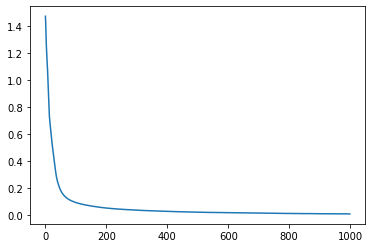

In [375]:
plt.plot(losses)
plt.show()

In [376]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [377]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [-0.18980649 -0.24398603  9.022851   35.328453  ]
argmax를 한 후의 output은 3
accuracy는 0.9783333333333334


뉴런의 수를 바꾸어도 정확도가 비슷하다.

In [378]:
result

,activation_f,optimizer,epoch,layer,lr,accuracy
0,Sigmoid,Adam,100,4,0.01,0.633333
1,tanh,Adam,1000,4,0.01,0.600000
2,nn.Relu,Adam,1000,4,0.01,0.973333
3,F.relu,Adam,1000,4,0.01,0.951667
4,nn.LeakyReLU,Adam,1000,4,0.01,0.970000
5,nn.Relu,SGD,1000,4,0.01,0.978333
6,nn.LeakyReLU,SGD,1000,4,0.01,0.980000
7,nn.LeakyReLU,SGD,1000,3,0.01,0.978333
8,nn.LeakyReLU,RMSprop,1000,4,0.01,0.965000


# 가장 정확도가 높은 결과는 

**Model7**    nn.LeakyReLU,	SGD,	epoch  : 1000,	layer:4,	lr:0.01일때 accuracy : 0.980000

-> 위 모델을 바탕으로 layer바꾸기, neuron수 바꾸기, lr바꾸기 epoch 바꾸기 해봤지만 더 성능이 좋아지지는 않았다